# Построить временной ряд для вокселя

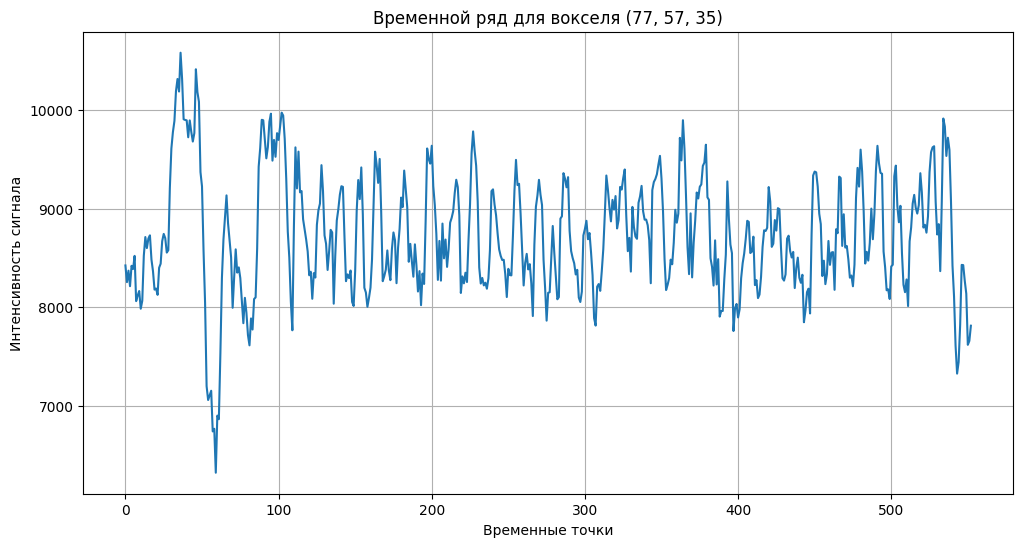

In [14]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
file_path = './data/HC/sub-02/denoised_data.nii.gz'  # укажите путь к вашему файлу
img = nib.load(file_path)
data = img.get_fdata()

# Выберите координаты вокселя (x, y, z, временная точка)
# Например, возьмем воксель в позиции (30, 30, 30) и все временные точки
x, y, z = 77, 57, 35
time_series = data[x, y, z, :]  # для 4D данных (3D + время)

# Построение графика
plt.figure(figsize=(12, 6))
plt.plot(time_series)
plt.title(f'Временной ряд для вокселя ({x}, {y}, {z})')
plt.xlabel('Временные точки')
plt.ylabel('Интенсивность сигнала')
plt.grid(True)
plt.show()

# То же самое, только с использованием NiftiMasker

In [7]:
from nilearn import datasets, plotting, image
from nilearn.maskers import NiftiLabelsMasker
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Загрузка фМРТ данных и атласа
fmri_path = './numpy_data/HC/sub-02.npy'
atlas_path = './atlas/atlas_resample.nii'  # Например, Schaefer, AAL, Harvard-Oxford

# Если нет своего атласа, можно загрузить стандартный:
# atlas = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
# atlas_path = atlas.maps

fmri_img = np.load(fmri_path)
atlas_img = nib.load(atlas_path)

In [8]:
# Создаем маскер для извлечения временных рядов по регионам атласа
masker = NiftiLabelsMasker(
    labels_img=atlas_img,
    standardize=False,       # Нормализация сигнала (z-score)
    detrend=True,          # Удаление линейного тренда
    low_pass=0.1,          # Низкочастотная фильтрация (если нужно)
    high_pass=0.01,        # Высокочастотная фильтрация (если нужно)
    t_r=2.0               # Время повторения (TR) в секундах (уточните для ваших данных!)
)

# Извлечение временных рядов для всех регионов
time_series_all_rois = fmri_img  # Форма: (timepoints, rois)
print(f"Размерность данных: {time_series_all_rois.shape} (временные точки × регионы)")

Размерность данных: (553, 132) (временные точки × регионы)


-1
Воксель (77, 57, 35) принадлежит региону 0.0


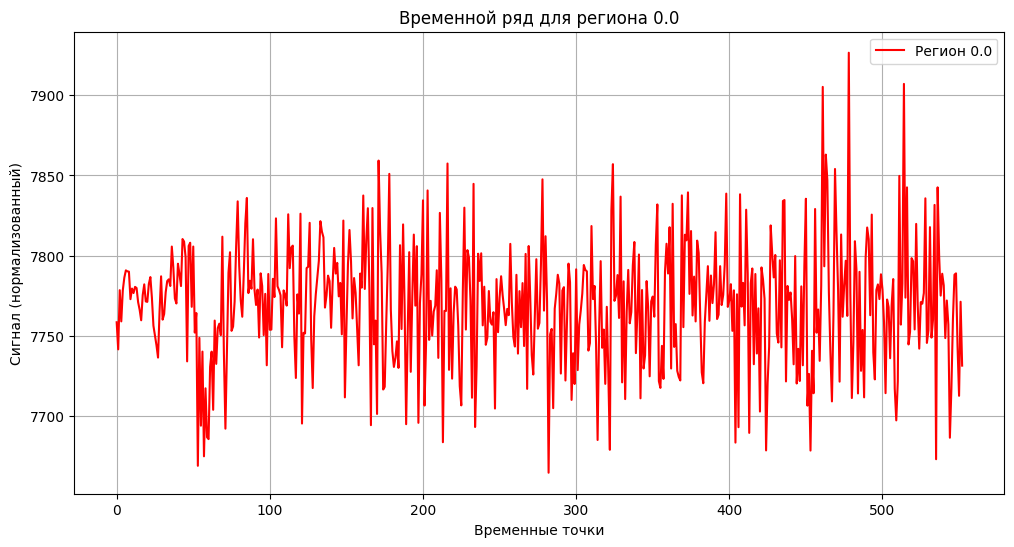

In [13]:
# Координаты вокселя (MNI или воксельные)
x, y, z = 77, 57, 35

# Определяем, к какому региону принадлежит воксель
atlas_data = atlas_img.get_fdata()
roi_value = atlas_data[x, y, z]
print(int(roi_value) - 1)
print(f"Воксель ({x}, {y}, {z}) принадлежит региону {roi_value}")

# Извлекаем сигнал для этого региона (если roi_value != 0)

roi_signal = time_series_all_rois[:, 131]  # Индексы начинаются с 0!

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(roi_signal, label=f'Регион {roi_value}', color='red')
plt.title(f'Временной ряд для региона {roi_value}')
plt.xlabel('Временные точки')
plt.ylabel('Сигнал (нормализованный)')
plt.legend()
plt.grid(True)
plt.show()

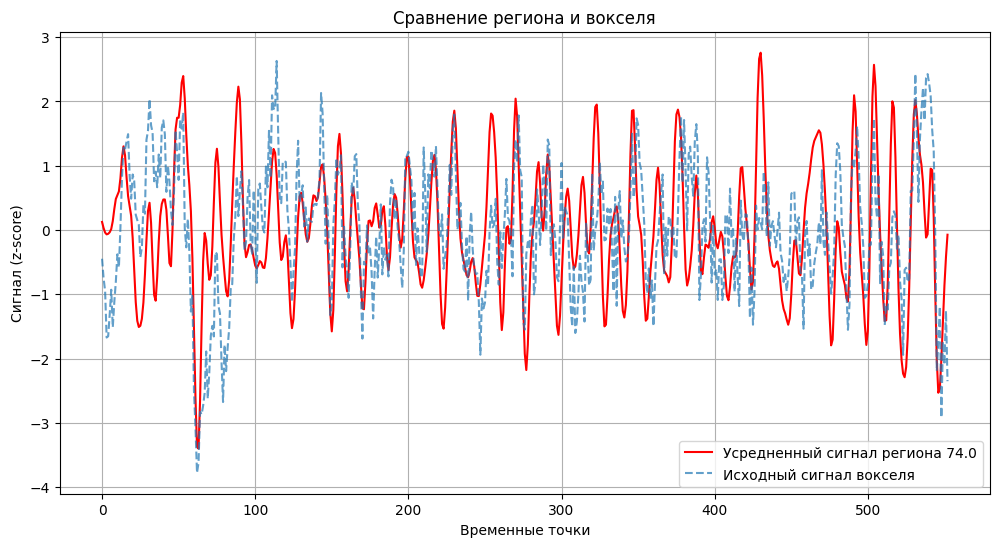

In [12]:
# Для проверки: извлечем сигнал вручную из исходных данных
raw_fmri_data = fmri_img.get_fdata()
voxel_signal = raw_fmri_data[x, y, z, :]

# Нормализуем для сравнения
voxel_signal = (voxel_signal - np.mean(voxel_signal)) / np.std(voxel_signal)

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(roi_signal, label=f'Усредненный сигнал региона {roi_value}', color='red')
plt.plot(voxel_signal, label='Исходный сигнал вокселя', linestyle='--', alpha=0.7)
plt.title('Сравнение региона и вокселя')
plt.xlabel('Временные точки')
plt.ylabel('Сигнал (z-score)')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
import numpy as np
matrix = np.load('./results/ranks_matrix.npy')
N = matrix.shape[0]  # Длина массива
labels = np.zeros(N, dtype=int)  # Создаем массив из нулей
labels[3::5] = 1  # Каждый 4-й элемен
print(labels)
X = matrix
y = labels

[0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 1 0]


In [81]:
from sklearn.model_selection import GroupShuffleSplit

# Группы для разделения (17 испытуемых → 17 групп)
groups = np.repeat(np.arange(17), 5)  # [0,0,0,0,0, 1,1,1,1,1, ..., 16,16,16,16,16]

splitter = GroupShuffleSplit(n_splits=1, test_size=0.35, random_state=42)
train_idx, test_idx = next(splitter.split(X, y, groups))

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "SVM": SVC(kernel='linear', class_weight='balanced', probability=True),
    "XGBoost": XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=3, scale_pos_weight=4, subsample=0.8)  # Вес для класса 1: 68/17 = 4
}

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = XGBClassifier(scale_pos_weight=1)  # Теперь классы сбалансированы SMOTE
model.fit(X_train_smote, y_train_smote)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))



# for name, model in models.items():
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_proba = model.predict_proba(X_test)[:, 1]
    
#     print(f"\n{name}")
#     print(classification_report(y_test, y_pred))
#     print("ROC-AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        24
           1       0.86      1.00      0.92         6

    accuracy                           0.97        30
   macro avg       0.93      0.98      0.95        30
weighted avg       0.97      0.97      0.97        30

ROC-AUC: 0.9791666666666667


In [84]:
matrix_test = np.load('./results/test_matrix.npy')

In [85]:
N = matrix_test.shape[0]  # Длина массива
labels_test = np.zeros(N, dtype=int)  # Создаем массив из нулей
labels_test[3::5] = 1  # Каждый 4-й элемен

In [86]:
labels_test

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0])

In [87]:
predict = model.predict(matrix_test)
predict

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0])

In [88]:
predict - labels_test

array([ 0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,
        0, -1,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])